In [147]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Abstract Data Types

Nous commencons par créer une classe Sequence, qui est l'ADT qui représente une séquence d’acides aminés et toutes les opérations qu’on  peut  exécuter  sur  une  séquence (exemple:  retourner  un  acide  aminé  à  une  certaine  position ou visualiser la séquence en format FASTA).

In [148]:
class Sequence:
    def __init__(self, acids, annotation=None):
        self.acids = acids
        self.annotation = annotation
        
    def __getitem__(self, position):
        """ Renvoie l'acide aminé à la position donnée. Syntaxe: sequence[position] """
        return self.acids[position]
    
    def toFASTAFormat(self):
        return ">" + self.annotation + "\n" + self.acids
    
    def __repr__(self):
        return "Annotation: %s \nAcids: %s" % (self.annotation, self.acids)
    
    def length(self):
        return len(self.acids)
        

Nous créeons aussi une classe Score, qui est un ADT qui représente une matrice de substitution et les opérations qu'on peut exécuter sur cette matrice.

In [149]:
class Score:
    def __init__(self, matrix):
        self.matrix = matrix
    
    def getNumLetters(self):
        return len(self.matrix)
    
    def getLetters(self):
        return self.matrix.keys()

    def getCost(self, a, b):
        return self.matrix[a.upper()][b.upper()]

## Parser

Nous devons créer des objets des classes Sequence et Score à partir des fichiers fournis. Il faut donc créer un parser pour les fichier des séquences (FASTA) et pour les fichiers avec les matrices de substitution (BLOSUM et PAM).

## FASTA

Les séquences d'acides aminés sont codées dans le format FASTA. Ce format est très simple.
Chaque séquence est encodée par une annotation et ensuite la liste d'acides aminés. Voici un exemple:

>&gt;sp|Q13526|PIN1_HUMAN Peptidyl-prolyl cis-trans isomerase NIMA-interacting 1 OS=Homo sapiens GN=PIN1 PE=1 SV=1
MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGKNGQGEPARVRCSHL
LVKHSQSRRPSSWRQEKITRTKEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARG
DLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE

La prèmiere ligne (qui commence par >) est une annotation contenant des informations sur la séquence. Ensuite viennent une série de lignes contenant la séquence d'acides aminés (avec un maximum de 80 caractères par ligne, en général, pour faciliter la lisibilité). 

Un fichier FASTA est constitué d'une série de séquences formattées de cette façon.

In [150]:
def parseFASTASequencesFromFile(filename):
    with open(filename, 'r') as f:
        return parseFASTASequences(f)

def parseFASTASequences(lines):
    sequences = []
    annotation, acids = "", ""
    for line in lines:
        line = line.strip()

        justEndedPreviousSequence = (len(line) == 0 or line.startswith(">")) and acids != ""
        if justEndedPreviousSequence:
            sequences.append(Sequence(acids, annotation))

        if line.startswith(">"):
            annotation = line[1:]
            acids = ""
        else:
            acids += line

    return sequences


Appliquons ces parsers aux fichiers donnés:

In [151]:
sequencesFilenames = ['protein-sequences.fasta', 'WW-sequence.fasta']
proteinSequences, wwSequences = [parseFASTASequencesFromFile(filename) for filename in sequencesFilenames]

sequence = proteinSequences[0]

Faisons quelques tests pour vérifier notre fonction:

In [152]:
print("La première sequence est: \n")
print(sequence)

La première sequence est: 

Annotation: sp|P46937|YAP1_HUMAN Transcriptional coactivator YAP1 OS=Homo sapiens GN=YAP1 PE=1 SV=2 
Acids: MDPGQQPPPQPAPQGQGQPPSQPPQGQGPPSGPGQPAPAATQAAPQAPPAGHQIVHVRGDSETDLEALFNAVMNPKTANVPQTVPMRLRKLPDSFFKPPEPKSHSRQASTDAGTAGALTPQHVRAHSSPASLQLGAVSPGTLTPTGVVSGPAATPTAQHLRQSSFEIPDDVPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRKAMLSQMNVTAPTSPPVQQNMMNSASGPLPDGWEQAMTQDGEIYYINHKNKTTSWLDPRLDPRFAMNQRISQSAPVKQPPPLAPQSPQGGVMGGSNSNQQQQMRLQQLQMEKERLRLKQQELLRQAMRNINPSTANSPKCQELALRSQLPTLEQDGGTQNPVSSPGMSQELRTMTTNSSDPFLNSGTYHSRDESTDSGLSMSSYSVPRTPDDFLNSVDEMDTGDTINQSTLPSQQNRFPDYLEAIPGTNVDLGTLEGDGMNIEGEELMPSLQEALSSDILNDMESVLAATKLDKESFLTWL


In [153]:
print("\nLe premier acide aminé de la séquence est: " + sequence[0])


Le premier acide aminé de la séquence est: M


### Matrices de substitution

Les matrices de substitution sont aussi dans un format simple et intuitif. Le fichier commence par quelques lignes de commentaires (commencent par #) et puis est suivi de la grille des coûts de substitution.

Voici un exemple simplifié:

>```
# Ma matrice
# Il y 5 acides aminés dans cet exemple
   A  R  N  D  C
A  4 -1 -2 -2  0 -
R -1  5  0 -2 -3  
N -2  0  6  1 -3  
D -2 -2  1  6 -3  
C  0 -3 -3 -3  9 
```

In [154]:
def parseSubstitutionMatrixFromFile(filename):
    with open(filename, 'r') as f:
        return parseSubstitutionMatrix(f)

def parseSubstitutionMatrix(lines):
    matrix = {}
    
    for line in lines:
        if line.startswith('#') or line.strip() == "": # Skip comments
            continue
        elif line.startswith('  '): # First line with letters
            letters = line.strip().split()
        else:
            letter, *costs = line.strip().split()
            matrix[letter] = {}
            for (i, cost) in enumerate(costs):
                matrix[letter][letters[i]] = int(cost)
    
    return Score(matrix)


Essayons d'appliquer ce parser à nos fichiers:

In [155]:
matricesFilenames = ['blosum62.txt', 'blosum80.txt', 'pam60.txt', 'pam120.txt']
blosum62, blosum80, pam60, pam120 = [parseSubstitutionMatrixFromFile(filename) for filename in matricesFilenames]

print("\nLe coût de subsition de R et C dans Blosum62 devrait être -3 et est %d" % blosum62.getCost('R', 'C'))
letters = blosum62.getLetters()
print("Il y a %d colonnes dans Blosum62: %s" % (len(letters), ''.join(sorted(letters))))


Le coût de subsition de R et C dans Blosum62 devrait être -3 et est -3
Il y a 24 colonnes dans Blosum62: *ABCDEFGHIKLMNPQRSTVWXYZ


# L'alignement de séquences

Une approche pour comparer des séquences d'acides (et donc des protéines) et d'examiner leur similarité. Une approche courante est d'essayer de voir quelles séquences "s'alignent" le mieux. En d'autres mots, est-il facile de faire correspondre des acides aminés entre les 2 séquences? 

En quantifiant la difficulté d'alignement, on peut donc quantifier la similarité entre séquences d'acides aminés, et donc d'automatiquement comparer de grandes quantités de protéines.

# Alignement global 

Maintenant qu'on a défini ces ADT, on peut commencer à implementer les algorithmes d'alignement. Pour l'alignement global, nous allons implémenter l'algorithme de *Needleman-Wunsch* avec une penalité affine.

## L'algorithme de Needleman-Wunsch

Cet algorithme se base sur l'idée que le problème d'alignement est équivalent au problème de la distance d'édition. On utilise donc la même approche pour résoudre ce problème.

Le premier pas est de construire une *matrice des scores*. Que répresente cette matrice?

**TODO: bien expliquer ca**

Pour la calculer, on utilise une approche de programmation dynamique. Ainsi, pour arriver à une certaine case X, on a soit:

1. Fait correspondre la lettre précedente de la séquence 1 à un espace (on vient de la case du haut)
2. Fait correspondre la lettre précedente de la séquence 2 à un espace (on vient de la case de gauche)
3. Fait correspondre la lettre précedente de la séquence 1 avec la lettre précedente de la séquence 2 (on vient de la case en diagonale)

Pour chacune des trois possibilités, on prend le cout de la case précedente et on y ajoute le cout de la transformation vers la case courante. Pour cela, on doit connaître le coût de la correspondance entre 2 acides aminés (dans les matrices PAM et BLOSUM, par exemple) et celui entre un acide aminé et un espace.

Le score final sera le maximum de ces 3 scores.

![Algorithme sans penalité affine](images/globalSimple.png)

## Penalité affine
Lorsque la penalité est affine, cela vaut dire que commencer une séquence d'espaces a un coût différent que de la prolonger. Par exemple, le 1er espace peut avoir un cout de 10 alors que les espaces qui le suivent n'ont qu'un cout de 2.

Pour calculer le score d'une case, il y a maintenant beaucoup plus de possibilités, parce qu'il faut prendre en compte tous les voisins à gauche et en haut. Si implementé de facon naive, l'algorithme est en $O(m * n^2)$.

**TODO: comprendre pourquoi c'est cette complexité**

**TODO: expliquer comment les matrices V et W permettent de calculer les scores avec penalité affine**

**TODO: expliquer pourquoi cela nous donne de nouveau un coût en $O(n * m)$**

![Algorithme global avec penalité affine naif](images/globalAffineNaive.png)

Pour implémenter la penalité affine efficacement, il faut utiliser 2 matrices supplémentaires (V et W), permettant ainsi de rester en $O(n * m)$

![Algorithme global avec penalité affine efficace](images/globalAffineSmart.png)

Cette approche se base sur l'idée que: 

----------

In [156]:
def printMatrix(matrix):
    for line in matrix:
        print(line)

def makeMatrix(width, height, val=0):
    if type(val) in (int, str, bool):
        return [[val] * width for _ in range(height)]
    elif val == []:
        return [[[] for _ in range(width)]for _ in range(height)]
    else:
        return [[val for _ in range(width)]for _ in range(height)]

def getValue(matrix, x, y):
    if x < 0 or y < 0:
        return float('-inf')
    else:
        return matrix[y][x]

def getSolutionsFromArrowGridHelper(previous, k, x, y, isGlobal=True):
    completePaths = []
    incompletePaths = [[(x, y)]]
    numPaths = 1
    
    while len(incompletePaths) > 0 and len(completePaths) <= k:
        path = incompletePaths.pop()
        lastX, lastY = path[0]
            
        for (i, previousCoords) in enumerate(previous[lastY][lastX]):
            if i > 0: # 2+ paths from this cell
                numPaths += 1
                if numPaths > k: # No need to consider new paths if we already have enough
                    break
            
            # Ceci gère le cas où on fait de l'alignement local, que l'on décrit dans une section future)
            if not isGlobal and previousCoords is None:
                completePaths.append(path)
                continue
                
            newX, newY = previousCoords
            isComplete = (newX == 0 and newY == 0)
            
            if isComplete:
                completePaths.append([(newX, newY)] + path)
            else:
                incompletePaths.append([(newX, newY)] + path)

    return completePaths

def getSolutionsFromArrowGrid(previous, k, x=None, y=None, isGlobal=True):
    if x is None or y is None:
        x, y = len(previous[0]) - 1, len(previous) - 1
        
    return getSolutionsFromArrowGridHelper(previous, k, x, y, isGlobal)

def getPathScores(paths, s):
    pathScores = {}
    for path in paths:
        x, y = path[-1]
        pathScores[(x, y)] = s[y][x]
    
    return pathScores
            
def getBestGlobalAlignements(sequence1, sequence2, score, startGap=4, keepGap=1, k=1):
    """
    k: the maximum number of alignement returned (note: less than k alignements may be returned)
    """
    height, width = sequence1.length() + 1, sequence2.length() + 1
    v, w, s = [makeMatrix(width, height) for _ in range(3)]
    previous = makeMatrix(width, height, [])
    
    for i in range(1, width):
        s[0][i] = -(startGap + (i - 1) * keepGap)
        v[0][i] = float('-inf')
        previous[0][i] = [(i - 1, 0)]
    
    
    for i in range(1, height):
        s[i][0] = -(startGap + (i - 1) * keepGap)
        w[i][0] = float('-inf')
        previous[i][0] = [(0, i - 1)]
    
    
    
    for x in range(1, width):
        for y in range(1, height):
            v[y][x] = max(s[y - 1][x] - startGap, v[y - 1][x] - keepGap)
            w[y][x] = max(s[y][x - 1] - startGap, w[y][x - 1] - keepGap)
            replacementCost = score.getCost(sequence1[y - 1], sequence2[x - 1])

            costsMap = {
                (x, y - 1): v[y][x],
                (x - 1, y): w[y][x],
                (x - 1, y - 1): s[y - 1][x - 1] + replacementCost
            }

            s[y][x] = max(costsMap.values())

            for coord, cost in costsMap.items():
                if cost == s[y][x]:
                    previous[y][x].append(coord)

    score = s[height - 1][width - 1]
    paths = getSolutionsFromArrowGrid(previous, k)
    pathScores = getPathScores(paths, s)
    

    return s, paths, score, previous, pathScores

## Fonctions de visualisation

On définit quelques fonction pour visualiser les chemins et la matrice des scores, ce qui séra très utile pour
comprendre les actions de l'algorithme et les chemins créés.

In [157]:
from pprint import pprint
def showPath(path, matrix=None, seq1=None, seq2=None):
    x, y = path[-1]
    if matrix is None:
        height, width = x + 1, y + 1
    else:
        height, width = len(matrix), len(matrix[0])
    
    mat = makeMatrix(height, width)
    for x, y in path:
        mat[y][x] = 1
    
    matrix = np.array(mat)
    plt.matshow(mat, cmap='Greys')
    
    # Axis Labels
    addSequenceLabelsToAxis(seq1, seq2, withNumbers=False)
    
    plt.show()

def addSequenceLabelsToAxis(seq1, seq2, withNumbers=True):
    def getLabels(acids):
        if withNumbers:
            return ['0'] + ['%s -  %d' % (acid.upper(), i) for (i, acid) in enumerate(acids, start=1)]
        else:
            return ' ' + acids
    
    if seq1 is not None:
        plt.yticks(range(seq1.length() + 1), getLabels(seq1.acids))
        
    if seq2 is not None:
        plt.xticks(range(seq2.length() + 1), getLabels(seq2.acids))

def printColoredMatrix(matrix, arrowMatrix=None, seq1=None, seq2=None, figsize=(8, 8), arrowColor='blue'):
    matrix = np.array(matrix)
    fig, ax = plt.subplots(figsize=figsize)
    ax.matshow(matrix)

    # Values
    for (i, line) in enumerate(matrix):
        for (j, val) in enumerate(line):
            ax.text(j, i, str(val), va='center', ha='center')
    
    # Axis Labels
    addSequenceLabelsToAxis(seq1, seq2)
    
    # Arrows
    arrowprops = dict(facecolor=arrowColor, alpha=0.6, lw=0,
                  shrink=0.2, width=2, headwidth=7, headlength=7)
    
    if arrowMatrix is None:
        plt.show()
        return
    
    for (y, line) in enumerate(arrowMatrix):
        for (x, previousCells) in enumerate(line):
            for coords in previousCells:
                if coords is not None:
                    ax.annotate("", xy=coords, xytext=(x, y), arrowprops=arrowprops)
    
    plt.show()
 

## Alignement global: un exemple

Pour comprendre ce que fait l'algorithme, appliquons le à un exemple. On va aligner la séquence "writers" avec la séquence "vintner", voir l'alignement obtenu et visualiser la matrice de scores et le chemin.

The score matrix is



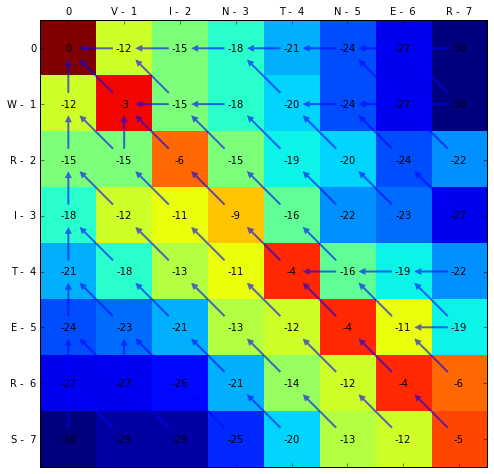

-5


In [158]:
a = Sequence('writers')
b = Sequence('vintner')

scoreMatrix, paths, score, arrowMatrix, pathScores = getBestGlobalAlignements(a, b, blosum62, startGap=12, keepGap=3, k=100)
print("The score matrix is\n")
printColoredMatrix(scoreMatrix, arrowMatrix, seq1=a, seq2=b)
print(score)

Number of paths found: 1



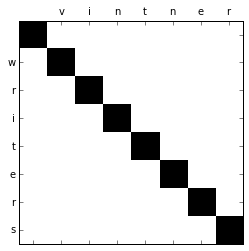

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]


In [159]:
print("Number of paths found: %d\n" % len(paths))
for path in paths:
    showPath(path, seq1=a, seq2=b)
    print(path)   

In [160]:
print("\nThe arrow matrix is\n")
printMatrix(arrowMatrix)


The arrow matrix is

[[], [(0, 0)], [(1, 0)], [(2, 0)], [(3, 0)], [(4, 0)], [(5, 0)], [(6, 0)]]
[[(0, 0)], [(0, 0)], [(1, 0), (1, 1)], [(2, 1)], [(3, 0)], [(4, 1)], [(5, 1), (5, 0)], [(6, 1), (6, 0)]]
[[(0, 1)], [(0, 1), (1, 1)], [(1, 1)], [(2, 1)], [(3, 1)], [(4, 1)], [(5, 1)], [(6, 1)]]
[[(0, 2)], [(0, 2)], [(1, 2)], [(2, 2)], [(3, 2)], [(4, 2)], [(5, 2)], [(6, 2)]]
[[(0, 3)], [(0, 3)], [(1, 3)], [(2, 3)], [(3, 3)], [(4, 4), (4, 3)], [(5, 4)], [(6, 4)]]
[[(0, 4)], [(0, 4)], [(1, 4)], [(2, 4)], [(3, 4)], [(4, 4)], [(5, 4)], [(6, 4), (6, 5)]]
[[(0, 5)], [(1, 5), (0, 5)], [(1, 5)], [(2, 5)], [(3, 5)], [(4, 5)], [(5, 5)], [(6, 5)]]
[[(0, 6)], [(0, 6)], [(1, 6)], [(2, 6)], [(3, 6)], [(4, 6)], [(5, 6)], [(6, 6)]]


# Retrouver les alignements

Une fois qu'on a fait retrouvé le chemin optimal, on peut créer l'alignement qui y correspond.

In [161]:
def showAlignments(path, sequence1, sequence2):
    text1, text2 = "", ""
    firstCoord, *remainingCoords = path
    prevX, prevY = firstCoord
    
    for (x, y) in remainingCoords:
        if x == prevX and y == prevY + 1: # Down
            text1 += sequence1[y - 1]
            text2 += "_"
        elif x == prevX + 1 and y == prevY: # Right
            text1 += "_"
            text2 += sequence2[x - 1]
        elif x == prevX + 1 and y == prevY + 1: # Diagonal
            text1 += sequence1[y - 1]
            text2 += sequence2[x - 1]
        
        prevX, prevY = x, y
    
    return text1, text2

def printAlignementResult(seq1, seq2, result, showScore = True, showLength = False):
    scoreMatrix, paths, score, arrowMatrix, pathScores = result
    if showScore:
        print("The best score is %d\n" % score)
        
    print(seq1, end="\n\n")
    print(seq2, end="\n\n")
    print("Alignements found: %d (may be artificially limited)\n" % len(paths))
    for (i, path) in enumerate(paths, start=1):
        if len(paths) > 0:
            print("Alignement number %d: " % i)
        
        text1, text2 = showAlignments(path, seq1, seq2)
        if showLength:
            print("The length of the alignement is %d" % len(text1))
            
        print("Alignment score: %d" % pathScores[path[-1]])
            
        print(text1)
        print(text2)
        print()

Maintenant qu'on a définit la fonction, regardons l'alignement créé pour l'exemple.

In [162]:
def compareSequences(seq1, seq2, matrix=blosum62, startGap=4, keepGap=1, k=5, showScore=True):
    result = getBestGlobalAlignements(seq1, seq2, matrix, startGap, keepGap, k)
    scoreMatrix, score, previous, arrowMatrix, pathScores = result
    printAlignementResult(seq1, seq2, result, showScore)
    #printColoredMatrix(scoreMatrix, arrowMatrix)

compareSequences(a, b, startGap=12, keepGap=3)

The best score is -5

Annotation: None 
Acids: writers

Annotation: None 
Acids: vintner

Alignements found: 1 (may be artificially limited)

Alignement number 1: 
Alignment score: -5
writers
vintner



Prenons des séquences réelles (présentes dans le fichier *ww-sequences.fasta*) et comparons-les.

In [163]:
ww1, ww2, ww5 = wwSequences[0], wwSequences[1], wwSequences[4]
compareSequences(ww1, ww2)

The best score is 77

Annotation: sp|P46937|171-204 
Acids: VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK

Annotation: sp|P46934|610-643 
Acids: SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP

Alignements found: 1 (may be artificially limited)

Alignement number 1: 
Alignment score: 77
VPLPAGWEMAKTSSGQRYFLNHIDQTTTWQDPRK
SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP



On peut regarder quelle paires de séquences du fichier *ww-sequences.fasta* ont les meilleurs alignements.

In [164]:
import itertools

def getBestMatches(sequences):
    bestScore = float('-inf')
    bestResults = {}
    
    for seq1, seq2 in itertools.combinations(sequences, 2):
        scoreMatrix, paths, score, arrowMatrix, pathScores = result = getBestGlobalAlignements(seq1, seq2, blosum62, startGap=4, keepGap=1, k=5)
        if score > bestScore:
            bestScore = score
            bestResults = {(seq1, seq2): result}
        elif score == bestScore:
            bestResults[(seq1, seq2)] = result
    
    return bestResults, bestScore

# TODO: improve perfomance. Right now it's dumb as a rock
bestResults, score = getBestMatches(wwSequences)
print("The best matches have a score of %d" % score)
print("They are between these sequences: ")
i = 1
for (seq1, seq2), result in bestResults.items():
    print("\n------------- Sequences %d -----------------\n" % i)
    printAlignementResult(seq1, seq2, result, showScore=False)
    i += 1

The best matches have a score of 117
They are between these sequences: 

------------- Sequences 1 -----------------

Annotation: sp|P46934|610-643 
Acids: SPLPPGWEERQDILGRTYYVNHESRRTQWKRPTP

Annotation: sp|P46934|892-925 
Acids: GPLPPGWEERTHTDGRIFYINHNIKRTQWEDPRL

Alignements found: 2 (may be artificially limited)

Alignement number 1: 
Alignment score: 117
SPLPPGWEER_Q_DILGRTYYVNHESRRTQWKRPTP
GPLPPGWEERTHTD__GRIFYINHNIKRTQWEDPRL

Alignement number 2: 
Alignment score: 117
SPLPPGWEER__QDILGRTYYVNHESRRTQWKRPTP
GPLPPGWEERTHTD__GRIFYINHNIKRTQWEDPRL



# TODO TODO TODO

![alt text](https://images.mysafetysign.com/img/lg/K/danger-sign-k-9458.png)


Comparez vos résultats avec les résultats produit par LALIGN 1 . 
Utilisez les séquences du fichier WW-sequence.fasta. Lorsque vous alignez les séquences 
WW, lesquelles sont les plus similaires ? Viennent-elles de la même protéine ou de protéines 
différentes ? Consultez ceci via le site Uniprot 3  et expliquez ceci dans votre Jupyter notebook. 

# Alignement local

Pour calculer l'alignement local entre séquences, on implémente l'algorithme de Smith-Waterman. Celui ci est extremement proche de l'algorithme de Needleman-Wunsch. Voici les différences:

![Alignement local](images/local.png)

Dans notre cas, on souhaite aussi trouver des alignement sous-optimaux (si il n'y en a pas assez d'optimaux).
On les trouve avec cette approche:

![Alignements sous-optimaux](images/suboptimal.png)

## Étape 1: sans alignements sous-optimaux

Nous allons d'abord commencer par implémenter une solution qui ne gère pas les alignements sous-optimaux. Dans la prochaine section, on s'occupera de mettre des valeurs à zéro, recalculer la matrice et trouver de nouveaux alignements (qui seront sous-optimaux).

In [165]:
def findMaximumsInMatrix(matrix):
    maximum = []
    maxVal = float('-inf')
    for (y, line) in enumerate(matrix):
        for (x, value) in enumerate(line):
            if value > maxVal:
                maxVal = value
                maximums = [(x, y)]
            elif value == maxVal:
                maximums.append((x, y))
    return maximums

def findMatrixMaxPosAndScore(matrix):
    bestCoords = None
    maxVal = float('-inf')
    for (y, line) in enumerate(matrix):
        for (x, value) in enumerate(line):
            if value > maxVal:
                maxVal = value
                bestCoords = (x, y)
            
    return bestCoords, maxVal

def getBestLocalPath(s, previous):
    (x, y), score = findMatrixMaxPosAndScore(s)
    
    if score == 0:
        return None, float('-inf')
    else:    
        paths = getSolutionsFromArrowGrid(previous, 1, x, y, isGlobal=False)
        path = paths[0]
        assert len(paths) == 1
        print("The paths found from (%d, %d) were %s" % (x, y, path))
        return path, score

def findBestLocalPaths(s, previous, pathsToFind):
    bestCoords = findMaximumsInMatrix(s)
    x, y = bestCoords[0]
    score = s[y][x]
    
    
    if score == 0:
        return [], float('-inf')
    
    paths = []
    pathsLeft = pathsToFind
    for (x, y) in bestCoords:
        newPaths = getSolutionsFromArrowGrid(previous, pathsLeft, x, y, isGlobal=False)
        
        paths.extend(newPaths)
        pathsLeft -= len(newPaths)
        if pathsLeft <= 0:
            break
    
    
    return paths, score
    
def computeMatrix(s, v, w, sequence1, sequence2, previous, scoreSub, startGap, keepGap):
    height, width = sequence1.length() + 1, sequence2.length() + 1
    for x in range(1, width):
        for y in range(1, height):
            v[y][x] = max(s[y - 1][x] - startGap, v[y - 1][x] - keepGap)
            w[y][x] = max(s[y][x - 1] - startGap, w[y][x - 1] - keepGap)
            replacementCost = scoreSub.getCost(sequence1[y - 1], sequence2[x - 1])

            costsMap = {
                (x, y - 1): v[y][x],
                (x - 1, y): w[y][x],
                (x - 1, y - 1): s[y - 1][x - 1] + replacementCost,
                None: 0
            }

            s[y][x] = bestScore = max(costsMap.values())
            # Lorsque le score est 0, ne pas calculer voisins
            if bestScore == 0:
                previous[y][x] = [None]
                continue
        
            for coord, cost in costsMap.items():
                if cost == bestScore:
                    previous[y][x].append(coord)

def getBestLocalAlignements(sequence1, sequence2, score, startGap=4, keepGap=1, l=1):
    """
    l: the maximum number of alignement returned (note: less than l alignements may be returned)
    """
    height, width = sequence1.length() + 1, sequence2.length() + 1
    v, w, s = [makeMatrix(width, height) for _ in range(3)]
    previous = makeMatrix(width, height, [])    
    
    pathsLeft = l
    computeMatrix(s, v, w, sequence1, sequence2, previous, score, startGap, keepGap)
    paths, bestScore = findBestLocalPaths(s, previous, pathsLeft)
    
    pathsLeft -= len(paths)
    pathScores = getPathScores(paths, s)
        
    return s, paths, bestScore, previous, pathScores

Observons les résultats de cette fonctions lorsqu'on utilise avec les séquences du premier exemple ("writers" et "vintner")

In [166]:
s1, s2 = a, b
result = getBestLocalAlignements(s1, s2, blosum62, startGap=4, keepGap=1, l=5)
printAlignementResult(s1, s2, result, showScore = True, showLength = True)

scoreMatrix, paths, score, arrowMatrix, pathScores = result

The best score is 11

Annotation: None 
Acids: writers

Annotation: None 
Acids: vintner

Alignements found: 1 (may be artificially limited)

Alignement number 1: 
The length of the alignement is 4
Alignment score: 11
t_er
tner



Visualisons la matrice des scores:

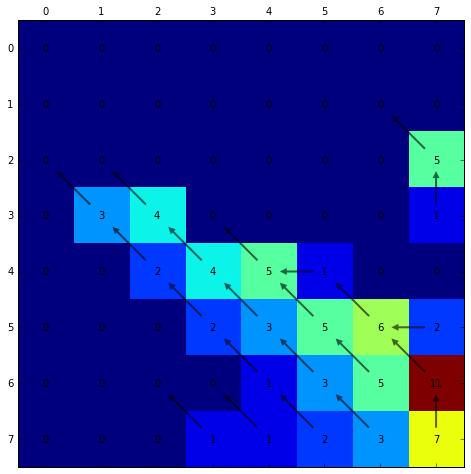

In [167]:
printColoredMatrix(scoreMatrix, arrowMatrix, figsize=(8, 8), arrowColor='black')

L'algorithm fonctionne correctement. On peut voir qu'il commence de la case avec score maximum (7, 6) et crée le chemin à partir de là. Visualisons ces chemins:

**TODO: check if we stop at the first 0 and can keep going**

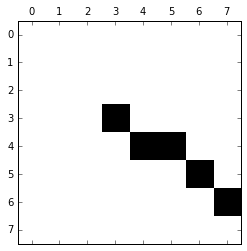

[(3, 3), (4, 4), (5, 4), (6, 5), (7, 6)]


In [168]:
for path in paths:
    showPath(path, scoreMatrix)
    print(path)

## Étape 2: avec alignements sous-optimaux

La prochaine étape est de calculer les alignements sous-optimaux (si il n'y a pas assez d'alignements locaux avec score maximal).

Imaginons qu'on ait trouvé le chemin avec le score maximal, comme dans l'image suivante:

![Alignement local optimal](images/localBeforeZeroing.png)

Après avoir trouvé la séquence à score maximal, on met toutes ces cellules à 0 et on recalcule la matrice dans le voisinage du chemin optimal, comme dans l'image suivante: 

![Alignements sous-optimaux](images/suboptimal.png)

In [169]:
def clearPathsAndRecomputeMatrix(s, v, w, sequence1, sequence2, path, scoreSub, previous, isInPath, startGap, keepGap):
    height, width = sequence1.length() + 1, sequence2.length() + 1
    
    
    # Mettre les valeurs des chemins à 0
    for (x, y) in path:
        s[y][x] = 0
        v[y][x] = 0
        w[y][x] = 0
        previous[y][x] = [None]
        isInPath[y][x] = True

    # Recalculer la matrice
    
    minX, minY = path[0]
    
    # Right now, we recompute everything, but we can stop earlier
    # An idea might be to stop if the new score is equal to the old score
    for x in range(minX, width):
        for y in range(minY, height):
            # Don't ever recompute a value that has been set to 0
            if isInPath[y][x]:
                continue
            
            v[y][x] = max(s[y - 1][x] - startGap, v[y - 1][x] - keepGap)
            w[y][x] = max(s[y][x - 1] - startGap, w[y][x - 1] - keepGap)
            replacementCost = scoreSub.getCost(sequence1[y - 1], sequence2[x - 1])

            costsMap = {
                (x, y - 1): v[y][x],
                (x - 1, y): w[y][x],
                (x - 1, y - 1): s[y - 1][x - 1] + replacementCost,
                None: 0
            }

            s[y][x] = bestScore = max(costsMap.values())
            if bestScore == 0:
                previous[y][x] = [None]
                continue
        
            # Cas spécial: les bords. Ils gardent un score 0 et n'ont pas de fleches
            if x == 0 or y == 0:
                previous[y][x] = [None]
                s[y][x] = 0
                continue
        
            previous[y][x] = []
            for coord, cost in costsMap.items():
                if cost == bestScore:
                    previous[y][x].append(coord)
    

    
def getAllBestLocalAlignements(sequence1, sequence2, scoreSub, startGap=4, keepGap=1, l=1, showMatrix=False):
    """
    l: the maximum number of alignement returned (note: less than l alignements may be returned)
    """
    height, width = sequence1.length() + 1, sequence2.length() + 1
    v, w, s = [makeMatrix(width, height) for _ in range(3)]
    previous = makeMatrix(width, height, [])   
    isInPath = makeMatrix(width, height, False)
    pathsLeft = l
    paths = []
    pathScores = {}
    
    for i in range(width):
        previous[0][i] = [None]
    
    for i in range(height):
        previous[i][0] = [None]
    
    # Find best paths
    computeMatrix(s, v, w, sequence1, sequence2, previous, scoreSub, startGap, keepGap)
    
    
    newPath, bestScore = getBestLocalPath(s, previous) 
    pathScores[newPath[-1]] = bestScore
    paths.append(newPath)
    pathsLeft -= 1
    
    if showMatrix:
        printColoredMatrix(s, previous, seq1=sequence1, seq2=sequence2)
    
    # If we don't find enough paths, keep searching for sub-optimal paths
    while pathsLeft > 0:
        clearPathsAndRecomputeMatrix(s, v, w, sequence1, sequence2, newPath, scoreSub, previous, isInPath, startGap, keepGap)
        
        if showMatrix:
            printColoredMatrix(s, previous, seq1=sequence1, seq2=sequence2)
        
        newPath, bestCurrentScore = getBestLocalPath(s, previous)  
        
        # No more good paths
        if newPath is None:
            print("Stopped searching because no good paths")
            break
        
        pathsLeft -= 1
        paths.append(newPath)
        lastX, lastY = newPath[-1]
        pathScores[newPath[-1]] = s[lastY][lastX]
        
    # TODO: remember the score associated with each path
    return s, paths, bestScore, previous, pathScores
    
    

Appliquons cette fonction à notre premier exemple ("writers" et "vintner"). Pour mieux comprendre l'évolution de la matrice des scores, elle est aussi affichée chaque fois qu'elle est recalculée.

In [170]:
s1, s2 = a, b
#s1, s2 = ww1, ww2
result = getAllBestLocalAlignements(s1, s2, blosum62, startGap=4, keepGap=1, l=10, showMatrix=False)
printAlignementResult(s1, s2, result, showScore = True, showLength = True)

scoreMatrix, paths, score, arrowMatrix, pathScores = result

The paths found from (7, 6) were [(3, 3), (4, 4), (5, 4), (6, 5), (7, 6)]
The paths found from (7, 2) were [(6, 1), (7, 2)]
The paths found from (2, 3) were [(1, 2), (2, 3)]
The paths found from (1, 3) were [(0, 2), (1, 3)]
The paths found from (3, 7) were [(2, 6), (3, 7)]
The paths found from (4, 7) were [(3, 6), (4, 7)]
The paths found from (5, 7) were [(4, 6), (5, 7)]
Stopped searching because no good paths
The best score is 11

Annotation: None 
Acids: writers

Annotation: None 
Acids: vintner

Alignements found: 7 (may be artificially limited)

Alignement number 1: 
The length of the alignement is 4
Alignment score: 11
t_er
tner

Alignement number 2: 
The length of the alignement is 1
Alignment score: 5
r
r

Alignement number 3: 
The length of the alignement is 1
Alignment score: 4
i
i

Alignement number 4: 
The length of the alignement is 1
Alignment score: 3
i
v

Alignement number 5: 
The length of the alignement is 1
Alignment score: 1
s
n

Alignement number 6: 
The length of t

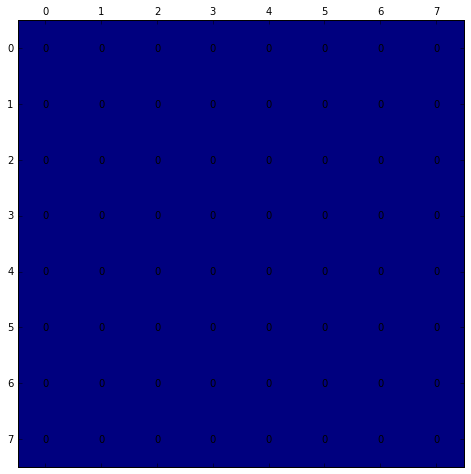

In [171]:
printColoredMatrix(scoreMatrix, arrowMatrix, figsize=(8, 8), arrowColor='black')

Visualisons les chemins créés:

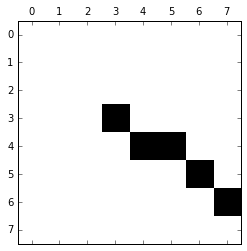

[(3, 3), (4, 4), (5, 4), (6, 5), (7, 6)]


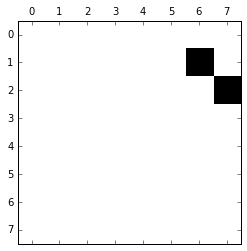

[(6, 1), (7, 2)]


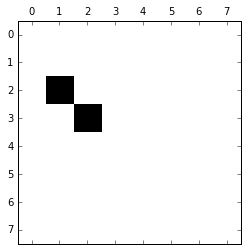

[(1, 2), (2, 3)]


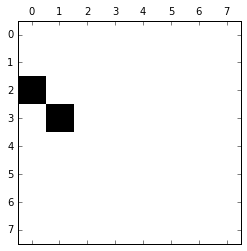

[(0, 2), (1, 3)]


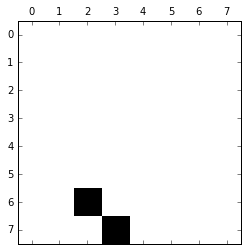

[(2, 6), (3, 7)]


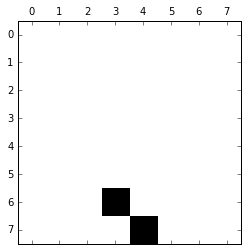

[(3, 6), (4, 7)]


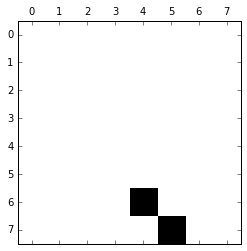

[(4, 6), (5, 7)]


In [172]:
for path in paths:
    showPath(path, scoreMatrix)
    print(path)

# TODO TODO TODO

![alt text](https://images.mysafetysign.com/img/lg/K/danger-sign-k-9458.png)


Comparez vos résultats avec l’outil LALIGN 1 . 
Utilisez les séquences du fichier protein-sequences.fasta et détectez quelles sont les 
parties similaires. Expliquez les similarités en utilisant les informations sur les protéines venant 
du site UniProt 2. 